# <center>ST590 Final Project</center>

#### <center>Pramodini Karwande and Ashley Ko </center>

## Introduction

This notebook uses supervised learning to fit models and make predictions from the [*Heart Failure Prediction Dataset*](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). As heart disease is the leading cause of death globally, we believed it would interest to examine this dataset with supervised learning methods.

The data was obtained via Kaggle and sourced from five different clinical data sets. It consists of 11 clinical features for predicting heart disease. These clinical features are:


* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* hestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]

This notebook seeks to fit models that predict for `HeartDisease`. As this attribute is categorical, we proceeded with classification methods.

## Supervised Learning Idea and Data Split

Supervised learning a type of machine learning model were a variable or variables is to represent a response. The goal of supervised learning is to make inference or make predictions . Algorithms are used to fit and select models for classification or prediction. In our case, we are using classification. 

One well known method of supervised learning is the generalized linear model. As our response data is binary, we specifically used logistic regression. Other methods include Tree based methods such as classification trees, random forest, or boosting. Tree models use recursive splitting of the predictor region. Classification trees are used for predicting group membership. This works well with our binary data. Random forest and boosting are tree based methods which averaged overall trees using bootstrap aggregation.

As we seek to predict the class of an observation as either 0 - Normal or 1 - Heart Disease, it is best practice to not predict on data that was used to fit the model. The reason for this is that novel data is necessary to accurately test your predictions. If a model was fit using the full data set, there aren't any novel observations. This leads to overfitting and inflated model accuracy.

The solution to the problem of overfitting is to split the full data set into training and testing data sets. Models will be fit and selected based on training data. Fitted models will be tested and predictions drawn from the test data set. Typically, a 80% train 20% test data split is used. We selected a 75% train and 25% test split to allow for adequate sample size.

### Data Splitting

We begin by reading in the `heart.csv` file into a pandas-on-Spark DataFrame. We chose to start with pandas-on-spark as it allows for easier manipulations for exploratory data analysis.

But first let's import the required libraries and set the notebook environment.

In [4]:
# Import packages
import os
import sys
import warnings
import pandas as pd
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Remove warnings from rendered output
warnings.filterwarnings("ignore")


# Set figure size
plt.rcParams["figure.figsize"] = (10,7)

# Spark Session builder
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.debug.maxToStringFields", "100").getOrCreate()

Here we are reading in the data as a pandas-on-Spark DataFrame.

In [5]:
# Read in data as pandas-on-Spark data frame
psdf_heart = ps.read_csv("heart.csv")
# Checking if import was successful
psdf_heart.head()

22/04/30 23:46:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/30 23:46:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Using `psdf_heart.info()` we determined learned the data type of the pandas-on-Spark variables. This allows us to determine if we need to transform variables to match their true data type. For example categorical data should be classified as such.

In [6]:
psdf_heart.info()

22/04/30 23:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/30 23:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int32  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int32  
 4   Cholesterol     918 non-null    int32  
 5   FastingBS       918 non-null    int32  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int32  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int32  
dtypes: float64(1), int32(6), object(5)

It looks like the categorical variables have all been stored as objects. Later, we will use transformations get these variables in our desired format.

Another potential issue would be the presence of null variables. Any null values should be processed to prevent errors.

In [7]:
# Check for null values
print(psdf_heart.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


As there are no null values, we elected to proceed with data splitting. We begin by converting our pandas-on-Spark DataFrame to a Pyspark SQL DataFrame.

In [8]:
# Make a Pyspark SQL dataframe from pandas-on-Spark df
sql_heart = psdf_heart.to_spark()

To the split the data into train and test data sets we used `randomSplit` with a split of 75/25 training to test. This was selected as a safe ratio allow for enough samples in both the training data and the test data.

In [9]:
train, test = sql_heart.randomSplit([0.75, 0.25], seed = 1234)
print(train.count(), test.count())

686 232


For some of the plotting, we need matplotlib. This requires a pandas DataFrame.

In [10]:
# Make a pandas DF from PySpark SQL df
pd_train = train.toPandas()

Other graphs and numeric summaries lent themselves better to using a pandas-on-Spark data set best fit our needs.

In [11]:
# Make a pandas-on-Spark DF from PySpark SQL df
psdf_train = train.to_pandas_on_spark()

## Exploratory Data Analysis

Exploring the training data allows us to better understand the relationship of the predictor and the response variables. It also alerts us to any unusual values.

We generated 8 number summaries for the `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`.

In [12]:
psdf_train[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,686.000000,686.000000,686.000000,686.000000,686.000000
mean,53.690962,132.091837,196.749271,136.677843,0.907289
std,9.282468,18.546025,111.301411,25.526051,1.074837
min,28.000000,0.000000,0.000000,60.000000,-2.000000
25%,48.000000,120.000000,170.000000,120.000000,0.000000
50%,54.000000,130.000000,222.000000,138.000000,0.600000
75%,60.000000,140.000000,265.000000,156.000000,1.500000
max,76.000000,200.000000,603.000000,202.000000,6.200000


From the summary table above, it is evident that there are potential outliers for `Cholesterol` and `RestingBP`. `Cholesterol`has a maximum of 603 which is more than two standard deviations above the mean. This observation is suspect, but more information of that particular observation would be needed before removing it. The minimum resting blood pressure and cholesterol are 0. `Cholesterol` and `RestingBP` of 0 is cause for concern. It could be that these values were not recorded or that these values are true measurements. We do not know for certain. Our concerns is that these observations might be over represented in either the test or training data and lead inaccurate model predictions or erroneously be selected as a good predictor for heart disease.

To assess the proportion of observations with either `Cholesterol` of 0 or `RestingBP` we obtained counts by filtering the `SPARK SQL` dataset accordingly.

First, let us look at the occurrences of a `RestingBP` of 0. The value below is the count from the training data set.

In [13]:
# Display counts for RestingBP of 0
print(train.filter(train.RestingBP == 0).count())

1


There is only a single observation with a `RestingBP` of 0. Because we cannot determine the reason for this value, we will continue to use this observation.

Now, let's examine counts for observations where `Cholesterol` is zero. The first value printed is the number of observations in the training and the second number is ratio of observations with heart disease and `Cholesterol` of 0 out of the total number of observations with heart disease in the training data.

In [14]:
# Display counts for Cholesterol of 0 and respective ratios for training and test data
print(train.filter(train.Cholesterol == 0).count(),
      train.filter(train.Cholesterol == 0)
      .filter(train.HeartDisease == 1).count()/
      train.filter(train.HeartDisease == 1).count())

135 0.3151041666666667


We calculated the proportion of observations with heart disease and cholesterol measurement of 0. This proportion is approximately 0.315.

There is a relatively weak correlation -0.246 between heart disease and cholesterol. However, given the general understanding of the relationship between heart disease, we decided to proceed with outlier observations and make note of this for further work.

In [15]:
psdf_train.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

22/04/30 23:47:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/30 23:47:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000,0.263,-0.114,0.217,-0.418,0.240,0.298
RestingBP,0.263,1.000,0.093,0.044,-0.113,0.151,0.103
Cholesterol,-0.114,0.093,1.000,-0.275,0.250,0.057,-0.246
FastingBS,0.217,0.044,-0.275,1.000,-0.169,0.049,0.277
MaxHR,-0.418,-0.113,0.250,-0.169,1.000,-0.185,-0.430
Oldpeak,0.240,0.151,0.057,0.049,-0.185,1.000,0.406
HeartDisease,0.298,0.103,-0.246,0.277,-0.430,0.406,1.000


The above table shows that no numeric variable has a correlation more extreme than -0.430 which is the correlation between heart disease and max heart rate. Oldpeak has a correlation of 0.406. These finding suggest that while there is some weak correlations to no correlation among the predictors. This is a good thing. However, the predictors are also only just weakly correlated with heart disease.

Now we will find aggregate means for each of the numeric variables based on Heart Disease.

In [16]:
psdf_summ_group = psdf_train.groupby('HeartDisease').agg(
    {'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], 'Cholesterol': ['mean', 'std'],
     'MaxHR': ['mean', 'std'], 'Oldpeak': ['mean', 'std']})
psdf_summ_group

22/04/30 23:47:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Age             RestingBP            Cholesterol                   MaxHR              Oldpeak          
                   mean       std        mean        std        mean         std        mean        std      mean       std
HeartDisease                                                                                                               
1             56.140625  8.400299  133.783854  20.245559  172.460938  128.289952  126.945312  23.208998  1.294271  1.161353
0             50.576159  9.429181  129.940397  15.903251  227.632450   74.434305  149.052980  22.867752  0.415232  0.692076

There are visible difference in the mean and standard deviations over `HeartDisease`. With the exception o `Cholesterol` and `MaxHR` all means and standard deviations are greater in observations flagged as having heart disease. With respect to Cholesterol, the difference in mean might be linked to previously mentioned the extreme maximum and minimum values.

Let's repeat above task to get mean and std for the given numeric variables based on sex. 

In [17]:
psdf_summ_sex = psdf_train.groupby('Sex').agg(
    {'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], 'Cholesterol': ['mean', 'std'],
     'MaxHR': ['mean', 'std'], 'Oldpeak': ['mean', 'std']})
psdf_summ_sex

Age             RestingBP            Cholesterol                   MaxHR              Oldpeak          
          mean       std        mean        std        mean         std        mean        std      mean       std
Sex                                                                                                               
F    52.514085  9.956455  131.873239  19.182904  238.049296   92.569570  145.556338  22.463374  0.687324  0.978119
M    53.998162  9.082900  132.148897  18.393837  185.968750  113.313598  134.360294  25.786608  0.964706  1.092248

When comparing means between male and female observations, we noted that there are not strong differences between sexes. However, the female `Cholesterol` mean is approximately 238 and the male mean is ~186. It is possible that this difference is due to the fact that women tend to have higher levels of HDL cholesterol than men.

Examining the center and spread of our numeric variables allowed us to identify unique points in `RestingBP` and `Cholesterol`. To visualize the shape and spread of these variables' distributions, when created histograms for each of the numeric variables.

First, let us look at the distribution of `Age`.

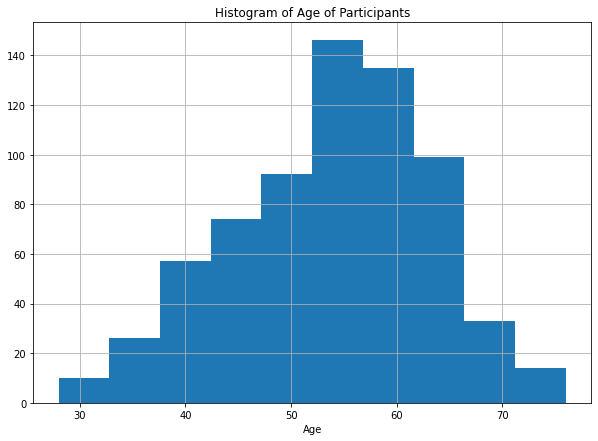

In [18]:
pd_train.Age.hist(bins = 10)
plt.xlabel("Age")
plt.title("Histogram of Age of Participants")
plt.show()

The histogram for `Age` shows a bell shaped left-skewed distribution. This is likely due to the fact that older individuals the ones most commonly assessed for heart disease. 

Next, we have a histogram of `RestingBP`.

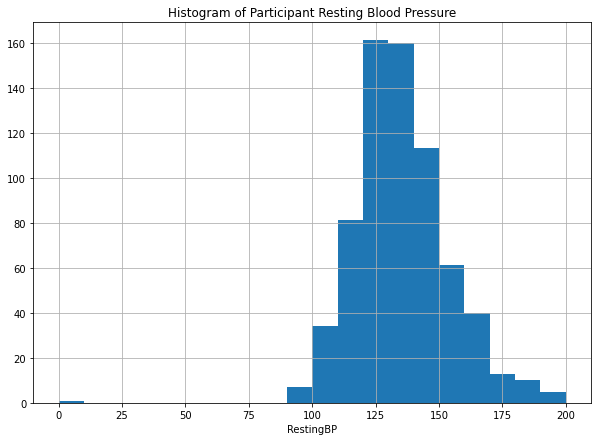

In [20]:
pd_train.RestingBP.hist(bins = 20)
plt.xlabel("RestingBP")
plt.title("Histogram of Participant Resting Blood Pressure")
plt.show()

Systolic blood pressure is typically greater than 100, which is what we see from this plot. There is one observation at zero which matches our previous finding.

Histogram for `Cholesterol`.

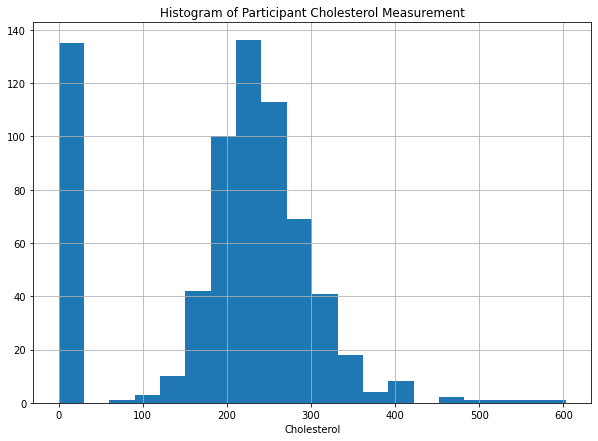

In [21]:
pd_train.Cholesterol.hist(bins = 20)
plt.xlabel("Cholesterol")
plt.title("Histogram of Participant Cholesterol Measurement")
plt.show()

Once again we see that many observations have `Cholesteral` of zero. At the upper end of the scale, you can see several values beyond 450. Most other observations are between 100 and 400. This matches our previous statistics.

Next, we have a histogram for `MaxHR`.

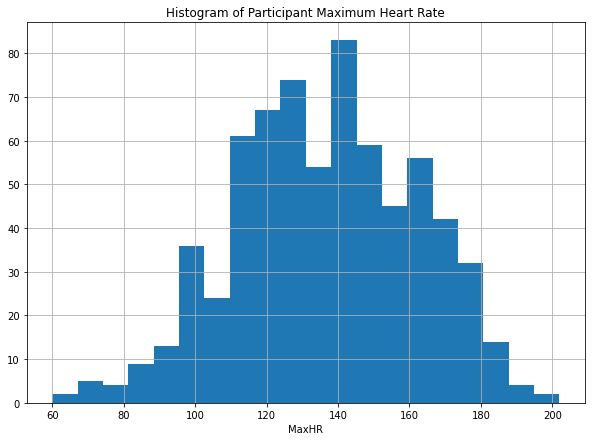

In [43]:
pd_train.MaxHR.hist(bins = 20)
plt.xlabel("MaxHR")
plt.title("Histogram of Participant Maximum Heart Rate")
plt.show()

`MaxHR` has a large spread. This histogram matches with the fact that `MaxHR` has a mean and standard deviation of ~25.

Our last histogram is for `Oldpeak`.

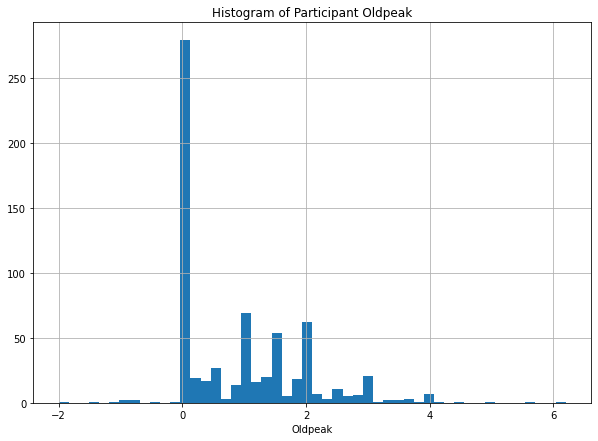

In [46]:
pd_train.Oldpeak.hist(bins = 50)
plt.xlabel("Oldpeak")
plt.title("Histogram of Participant Oldpeak")
plt.show()

`Oldpeak` has a rather unusual histogram with numerous observations at zero and no clear shape. The distribution almost looks as if this variable is more discrete than continuous. This histogram matches with the fact that `Oldspeak` values are generally small.

By now we have a pretty good sense of shape, spread, and center of the numeric predictor variables. Let's now examine how these components change when grouped by `HeartDisease`. To do this we will look at boxplots for each numeric variable plotted over `HeartDisease`.

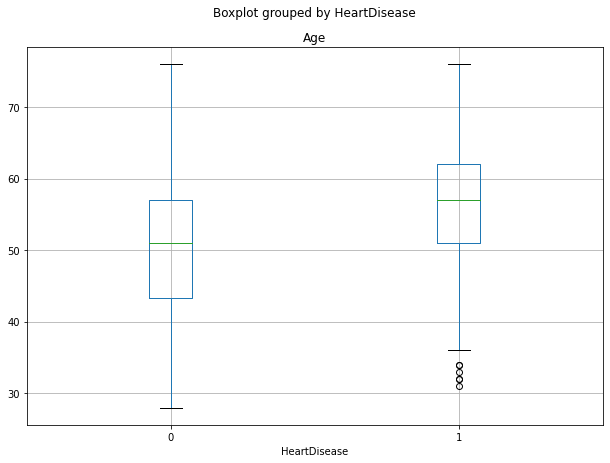

In [26]:
pd_train.boxplot(column = ['Age'], by = 'HeartDisease')
plt.show()

As shown by the 8 number summaries and aggregate mean and standard deviation tables, individual's with heart disease tend to be older. 

In [ ]:
Bo

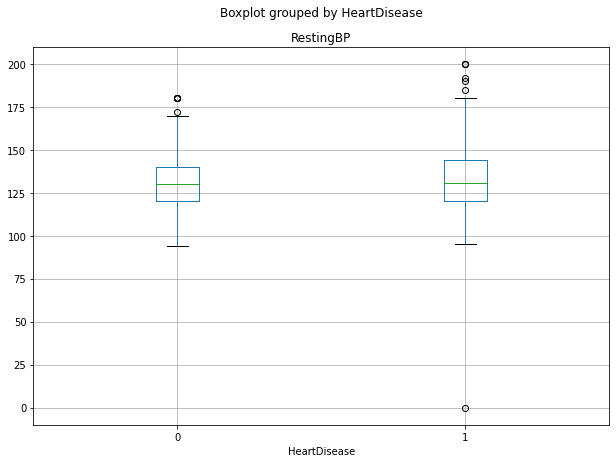

In [28]:
pd_train.boxplot(column = ['RestingBP'], by = 'HeartDisease')
plt.show()

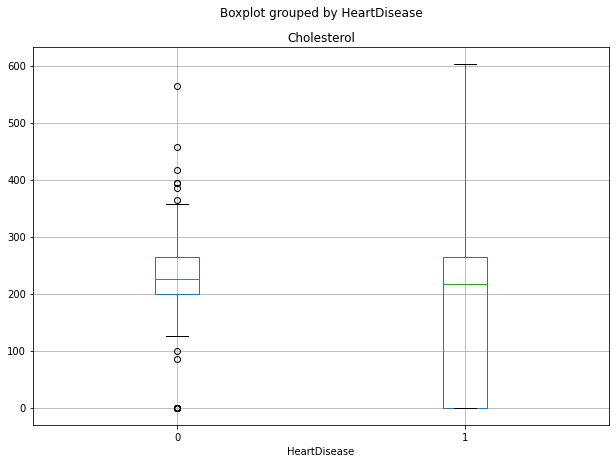

In [30]:
pd_train.boxplot(column = ['Cholesterol'], by = 'HeartDisease')
plt.show()

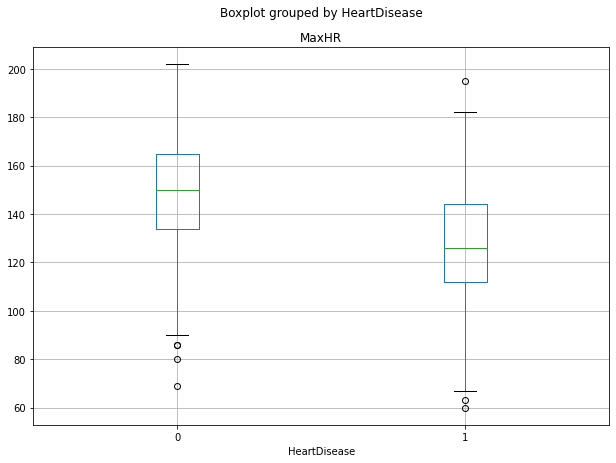

In [73]:
pd_train.boxplot(column = ['MaxHR'], by = 'HeartDisease')
plt.show()

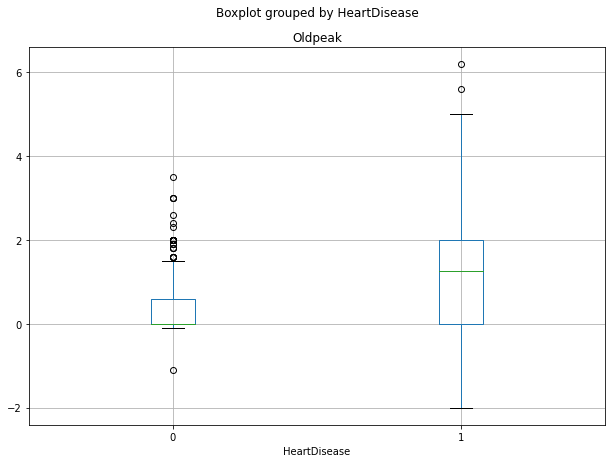

In [33]:
pd_train.boxplot(column = ['Oldpeak'], by = 'HeartDisease')
plt.show()

In [34]:
train.crosstab('HeartDisease', 'Sex').show()

+----------------+---+---+
|HeartDisease_Sex|  F|  M|
+----------------+---+---+
|               1| 38|346|
|               0|104|198|
+----------------+---+---+



In [35]:
train.crosstab('HeartDisease', 'ChestPainType').show()

+--------------------------+---+---+---+---+
|HeartDisease_ChestPainType|ASY|ATA|NAP| TA|
+--------------------------+---+---+---+---+
|                         1|299| 18| 53| 14|
|                         0| 78|106| 97| 21|
+--------------------------+---+---+---+---+



In [36]:
train.crosstab('HeartDisease', 'FastingBS').show()

+----------------------+---+---+
|HeartDisease_FastingBS|  0|  1|
+----------------------+---+---+
|                     1|250|134|
|                     0|269| 33|
+----------------------+---+---+



In [37]:
train.crosstab('HeartDisease', 'RestingECG').show()

+-----------------------+---+------+---+
|HeartDisease_RestingECG|LVH|Normal| ST|
+-----------------------+---+------+---+
|                      1| 69|   219| 96|
|                      0| 65|   194| 43|
+-----------------------+---+------+---+



In [38]:
train.crosstab('HeartDisease', 'ExerciseAngina').show()

+---------------------------+---+---+
|HeartDisease_ExerciseAngina|  N|  Y|
+---------------------------+---+---+
|                          0|262| 40|
|                          1|144|240|
+---------------------------+---+---+



In [39]:
train.crosstab('HeartDisease', 'ST_Slope').show()

+---------------------+----+----+---+
|HeartDisease_ST_Slope|Down|Flat| Up|
+---------------------+----+----+---+
|                    0|   9|  59|234|
|                    1|  36| 282| 66|
+---------------------+----+----+---+



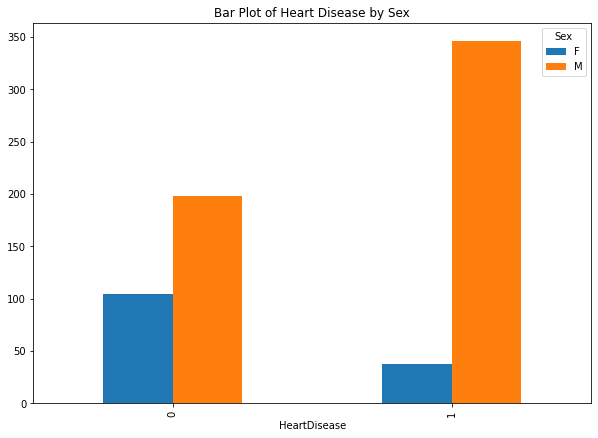

In [40]:
cat_data = pd_train[['HeartDisease', 'Sex', 'ChestPainType', 'FastingBS',
                     'RestingECG', 'ExerciseAngina', 'ST_Slope']]
table = pd.crosstab(cat_data.HeartDisease, cat_data.Sex)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Sex")
plt.show()

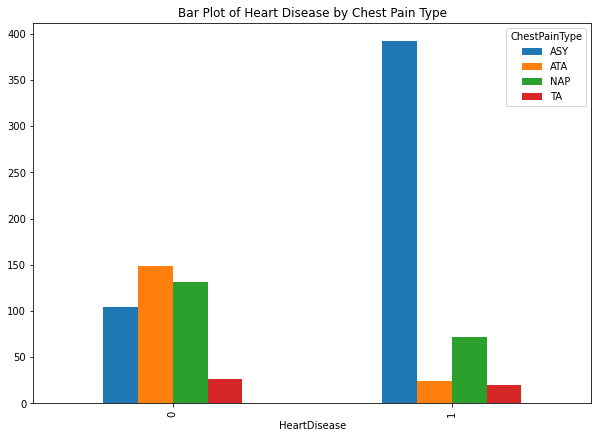

In [83]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.ChestPainType)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Chest Pain Type")
plt.show()

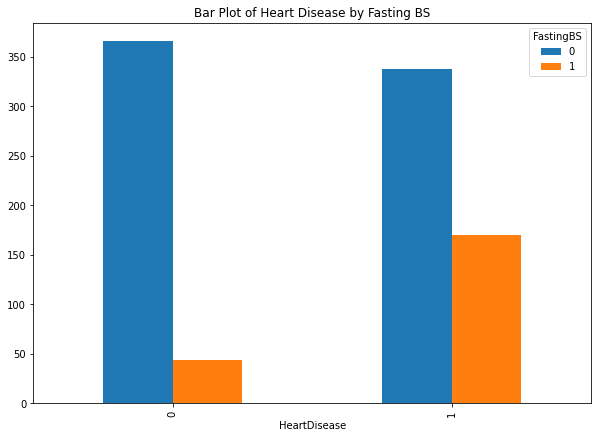

In [84]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.FastingBS)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Fasting BS")
plt.show()

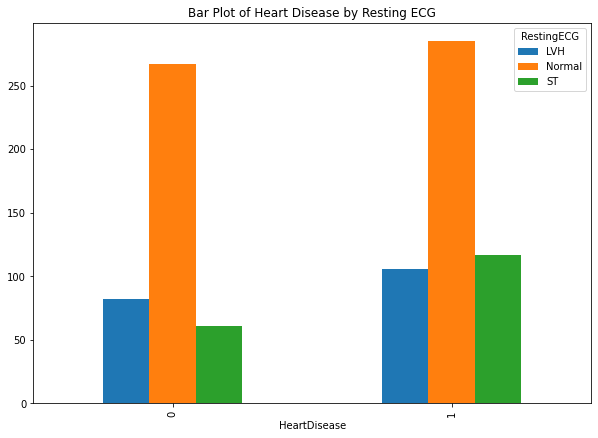

In [85]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.RestingECG)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Resting ECG")
plt.show()

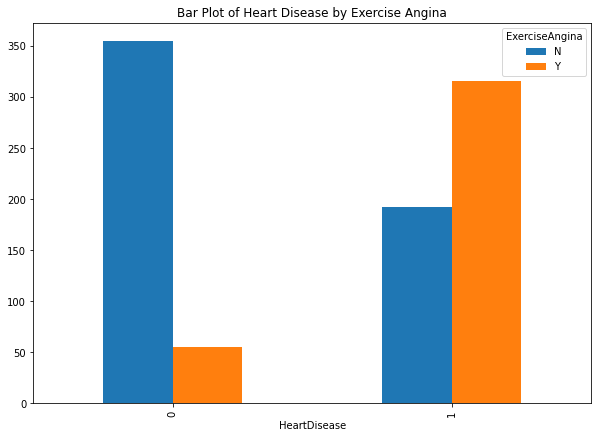

In [86]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.ExerciseAngina)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by Exercise Angina")
plt.show()

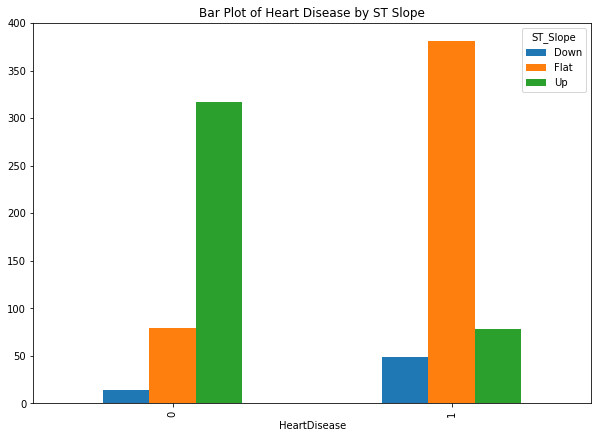

In [87]:
table = pd.crosstab(cat_data.HeartDisease, cat_data.ST_Slope)
table.plot.bar()
plt.title("Bar Plot of Heart Disease by ST Slope")
plt.show()

### Modeling

In [89]:
#import required library
from pyspark.ml.feature import StringIndexer, OneHotEncoder, SQLTransformer, VectorAssembler

In [90]:
sex_indexer = StringIndexer(inputCol = "Sex", outputCol="SexIndex")

chestPain_indexer = StringIndexer(inputCol = "ChestPainType", outputCol="ChestPainTypeIndex")

RestingECG_indexer = StringIndexer(inputCol = "RestingECG", outputCol="RestingECGIndex")

ExerciseAngina_indexer = StringIndexer(inputCol = "ExerciseAngina", outputCol="ExerciseAnginaIndex")

ST_Slope_indexer  = StringIndexer(inputCol = "ST_Slope", outputCol="ST_SlopeIndex")

In [91]:
encoder = OneHotEncoder().setInputCols(["SexIndex", "ChestPainTypeIndex", "RestingECGIndex",
                                        "ExerciseAnginaIndex", "ST_SlopeIndex"])\
                                 .setOutputCols(["Sex_encoded", "ChestPainType_encoded",
                                                 "RestingECG_encoded", "ExerciseAngina_encoded",
                                                 "ST_Slope_encoded"])

In [92]:
sqlTrans1 = SQLTransformer(
    statement = "SELECT Age, Sex_encoded, ChestPainType_encoded,"+
                "log(RestingBP) as log_RestingBP," + 
                "log(Cholesterol) as log_Cholesterol, FastingBS, RestingECG_encoded," +
                "log(MaxHR) as log_MaxHR, ExerciseAngina_encoded, Oldpeak," +
                "ST_Slope_encoded," +
                "HeartDisease as label FROM __THIS__"
)

In [93]:
assembler = VectorAssembler(inputCols = ["Age", "Sex_encoded", "ChestPainType_encoded", "log_RestingBP",
                                         "log_Cholesterol", "FastingBS", "RestingECG_encoded",
                                         "log_MaxHR", "ExerciseAngina_encoded", "Oldpeak",
                                         "ST_Slope_encoded"],
                            outputCol = "features",
                            handleInvalid = 'keep')

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [94]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [sex_indexer, chestPain_indexer, RestingECG_indexer,
                              ExerciseAngina_indexer, ST_Slope_indexer, encoder,
                              sqlTrans1,  assembler, lr])
model = pipeline.fit(sql_heart).transform(sql_heart)
model.select("label", "features").show()

NameError: name 'lr' is not defined

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10, 20, 50])
             .build())

# Evaluate model
lrevaluator = BinaryClassificationEvaluator()

# Create 5-fold CrossValidator
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = lrevaluator,
                          numFolds = 5)

In [ ]:
cvmodel = crossval.fit(train)